<a href="https://colab.research.google.com/github/RohanCheera/FaceTrace/blob/main/models/FACEGEN_Model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import shutil
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from google.colab import drive, files

# Mount Google Drive
drive.mount('/content/drive')

# Install required libraries with retry for torch-fidelity
def install_libraries():
    try:
        import torch_fidelity
        print("torch-fidelity already installed.")
    except ImportError:
        print("Installing torch-fidelity...")
        for _ in range(3):  # Retry up to 3 times
            try:
                !pip install torch torchvision opencv-python numpy torch-fidelity scikit-image kaggle -q
                import torch_fidelity
                print("torch-fidelity installed successfully.")
                break
            except ImportError:
                print("Retrying torch-fidelity installation...")
        else:
            raise ImportError("Failed to install torch-fidelity after multiple attempts. Please check your network or try restarting the runtime.")

install_libraries()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
torch-fidelity already installed.


In [ ]:

# Install required libraries
!pip install torch torchvision opencv-python numpy torch-fidelity scikit-image kaggle -q


In [ ]:
# Upload Kaggle API key
print("Upload your kaggle.json file:")
uploaded = files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Upload your kaggle.json file:


Saving kaggle.json to kaggle.json


In [ ]:
# Download CUFS dataset
!kaggle datasets download -d arbazkhan971/cuhk-face-sketch-database-cufs
!unzip -o -q cuhk-face-sketch-database-cufs.zip -d /content/cufs


Dataset URL: https://www.kaggle.com/datasets/arbazkhan971/cuhk-face-sketch-database-cufs
License(s): copyright-authors
cuhk-face-sketch-database-cufs.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Define paths
image_path = '/content/cufs/photos'
sketches_path = '/content/cufs/sketches'
project_folder = '/content/drive/MyDrive/CUFS'
train_sketch_dir = os.path.join(project_folder, 'train_sketches')
train_photo_dir = os.path.join(project_folder, 'train_photos')
test_sketch_dir = os.path.join(project_folder, 'test_sketches')
test_photo_dir = os.path.join(project_folder, 'test_photos')

In [ ]:
# Create directories
os.makedirs(train_sketch_dir, exist_ok=True)
os.makedirs(train_photo_dir, exist_ok=True)
os.makedirs(test_sketch_dir, exist_ok=True)
os.makedirs(test_photo_dir, exist_ok=True)

In [ ]:
# Split dataset into train and test
photo_files = sorted([f for f in os.listdir(image_path) if f.endswith(('.jpg', '.png'))])
sketch_files = sorted([f for f in os.listdir(sketches_path) if f.endswith(('.jpg', '.png'))])
assert len(photo_files) == len(sketch_files), "Mismatched photo-sketch pairs"

random.seed(42)
combined = list(zip(photo_files, sketch_files))
random.shuffle(combined)
photo_files, sketch_files = zip(*combined)

train_size = int(0.8 * len(photo_files))
train_photos = photo_files[:train_size]
train_sketches = sketch_files[:train_size]
test_photos = photo_files[train_size:]
test_sketches = sketch_files[train_size:]

In [ ]:
# Copy files to Google Drive
for photo, sketch in zip(train_photos, train_sketches):
    shutil.copy(os.path.join(image_path, photo), os.path.join(train_photo_dir, photo))
    shutil.copy(os.path.join(sketches_path, sketch), os.path.join(train_sketch_dir, sketch))

for photo, sketch in zip(test_photos, test_sketches):
    shutil.copy(os.path.join(image_path, photo), os.path.join(test_photo_dir, photo))
    shutil.copy(os.path.join(sketches_path, sketch), os.path.join(test_sketch_dir, sketch))

print(f"Total images: {len(photo_files)}")
print(f"Train photos: {len(train_photos)}, Train sketches: {len(train_sketches)}")
print(f"Test photos: {len(test_photos)}, Test sketches: {len(test_sketches)}")
print(f"Data stored in Google Drive at: {project_folder}")


Total images: 188
Train photos: 150, Train sketches: 150
Test photos: 38, Test sketches: 38
Data stored in Google Drive at: /content/drive/MyDrive/CUFS


In [ ]:
# Custom Dataset
class CUFSDataset(Dataset):
    def __init__(self, sketch_dir, photo_dir, transform=None, photo_transform=None):
        self.sketch_dir = sketch_dir
        self.photo_dir = photo_dir
        self.transform = transform
        self.photo_transform = photo_transform
        self.sketches = sorted([f for f in os.listdir(sketch_dir) if f.endswith(('.jpg', '.png'))])
        self.photos = sorted([f for f in os.listdir(photo_dir) if f.endswith(('.jpg', '.png'))])
        assert len(self.sketches) == len(self.photos), "Mismatched sketch-photo pairs"

    def __len__(self):
        return len(self.sketches)

    def __getitem__(self, idx):
        sketch_path = os.path.join(self.sketch_dir, self.sketches[idx])
        photo_path = os.path.join(self.photo_dir, self.photos[idx])

        sketch = cv2.imread(sketch_path, cv2.IMREAD_GRAYSCALE)
        photo = cv2.imread(photo_path)
        photo = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB)

        sketch = Image.fromarray(sketch)
        photo = Image.fromarray(photo)

        if self.transform:
            sketch = self.transform(sketch)
        if self.photo_transform:
            photo = self.photo_transform(photo)

        return sketch, photo, self.sketches[idx]  # Return filename for visualization


In [ ]:

# Data transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

photo_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets
train_dataset = CUFSDataset(
    sketch_dir=train_sketch_dir,
    photo_dir=train_photo_dir,
    transform=transform,
    photo_transform=photo_transform
)
test_dataset = CUFSDataset(
    sketch_dir=test_sketch_dir,
    photo_dir=test_photo_dir,
    transform=transform,
    photo_transform=photo_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
# Generator
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, out_channels, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# IPAM
class IPAM(nn.Module):
    def __init__(self):
        super(IPAM, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

    def forward(self, x):
        return self.feature_extractor(x)


In [ ]:

# Initialize models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G_sketch_to_photo = Generator(in_channels=1, out_channels=3).to(device)
G_photo_to_sketch = Generator(in_channels=3, out_channels=1).to(device)
D_sketch = Discriminator(in_channels=1).to(device)
D_photo = Discriminator(in_channels=3).to(device)
ipam = IPAM().to(device)

# Load VGG16 for perceptual loss
vgg = models.vgg16(pretrained=True).features[:16].to(device)
vgg.eval()

# Loss functions
adversarial_loss = nn.BCELoss()
cycle_loss = nn.L1Loss()
identity_loss = nn.L1Loss()
mae_loss = nn.L1Loss()

# Optimizers
g_optimizer = optim.Adam(list(G_sketch_to_photo.parameters()) + list(G_photo_to_sketch.parameters()), lr=0.0002, betas=(0.5, 0.999))
d_sketch_optimizer = optim.Adam(D_sketch.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_photo_optimizer = optim.Adam(D_photo.parameters(), lr=0.0002, betas=(0.5, 0.999))
ipam_optimizer = optim.Adam(ipam.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Schedulers
scheduler_g = optim.lr_scheduler.StepLR(g_optimizer, step_size=10, gamma=0.1)
scheduler_d_sketch = optim.lr_scheduler.StepLR(d_sketch_optimizer, step_size=10, gamma=0.1)
scheduler_d_photo = optim.lr_scheduler.StepLR(d_photo_optimizer, step_size=10, gamma=0.1)
scheduler_ipam = optim.lr_scheduler.StepLR(ipam_optimizer, step_size=10, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:


# Training loop
num_epochs = 50
lambda_cycle = 10.0
lambda_identity = 5.0
losses_g = []
losses_d_sketch = []
losses_d_photo = []

for epoch in range(num_epochs):
    epoch_g_loss = 0.0
    epoch_d_sketch_loss = 0.0
    epoch_d_photo_loss = 0.0
    for i, (sketches, photos, _) in enumerate(train_dataloader):
        sketches = sketches.to(device)
        photos = photos.to(device)

        # Train Discriminators
        d_sketch_optimizer.zero_grad()
        d_photo_optimizer.zero_grad()

        real_sketch_output = D_sketch(sketches)
        real_photo_output = D_photo(photos)
        real_label = torch.ones_like(real_sketch_output).to(device)
        d_sketch_real_loss = adversarial_loss(real_sketch_output, real_label)
        d_photo_real_loss = adversarial_loss(real_photo_output, real_label)

        fake_photos = G_sketch_to_photo(sketches)
        fake_sketches = G_photo_to_sketch(photos)
        fake_sketch_output = D_sketch(fake_sketches.detach())
        fake_photo_output = D_photo(fake_photos.detach())
        fake_label = torch.zeros_like(fake_sketch_output).to(device)
        d_sketch_fake_loss = adversarial_loss(fake_sketch_output, fake_label)
        d_photo_fake_loss = adversarial_loss(fake_photo_output, fake_label)

        d_sketch_loss = (d_sketch_real_loss + d_sketch_fake_loss) / 2
        d_photo_loss = (d_photo_real_loss + d_photo_fake_loss) / 2
        d_sketch_loss.backward()
        d_photo_loss.backward()
        d_sketch_optimizer.step()
        d_photo_optimizer.step()

        # Train Generators
        g_optimizer.zero_grad()
        ipam_optimizer.zero_grad()

        fake_photos = G_sketch_to_photo(sketches)
        fake_sketches = G_photo_to_sketch(photos)
        fake_photo_output = D_photo(fake_photos)
        fake_sketch_output = D_sketch(fake_sketches)
        g_photo_adv_loss = adversarial_loss(fake_photo_output, real_label)
        g_sketch_adv_loss = adversarial_loss(fake_sketch_output, real_label)

        cycle_sketches = G_photo_to_sketch(fake_photos)
        cycle_photos = G_sketch_to_photo(fake_sketches)
        cycle_sketch_loss = cycle_loss(cycle_sketches, sketches) * lambda_cycle
        cycle_photo_loss = cycle_loss(cycle_photos, photos) * lambda_cycle

        ipam_real = ipam(photos)
        ipam_fake = ipam(fake_photos)
        ipam_loss = identity_loss(ipam_fake, ipam_real) * lambda_identity

        g_loss = g_photo_adv_loss + g_sketch_adv_loss + cycle_sketch_loss + cycle_photo_loss + ipam_loss
        g_loss.backward()
        g_optimizer.step()
        ipam_optimizer.step()

        # Update schedulers
        scheduler_g.step()
        scheduler_d_sketch.step()
        scheduler_d_photo.step()
        scheduler_ipam.step()

        epoch_g_loss += g_loss.item()
        epoch_d_sketch_loss += d_sketch_loss.item()
        epoch_d_photo_loss += d_photo_loss.item()

        if i % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(train_dataloader)}] '
                  f'D_Sketch Loss: {d_sketch_loss.item():.4f} D_Photo Loss: {d_photo_loss.item():.4f} '
                  f'G Loss: {g_loss.item():.4f}')

    # Average losses for the epoch
    losses_g.append(epoch_g_loss / len(train_dataloader))
    losses_d_sketch.append(epoch_d_sketch_loss / len(train_dataloader))
    losses_d_photo.append(epoch_d_photo_loss / len(train_dataloader))





Epoch [1/50] Batch [0/38] D_Sketch Loss: 0.7167 D_Photo Loss: 0.7234 G Loss: 16.8326
Epoch [1/50] Batch [10/38] D_Sketch Loss: 0.5455 D_Photo Loss: 0.5532 G Loss: 6.7668
Epoch [1/50] Batch [20/38] D_Sketch Loss: 0.4058 D_Photo Loss: 0.4961 G Loss: 6.2538
Epoch [1/50] Batch [30/38] D_Sketch Loss: 0.4174 D_Photo Loss: 0.5044 G Loss: 6.2735
Epoch [2/50] Batch [0/38] D_Sketch Loss: 0.4570 D_Photo Loss: 0.5031 G Loss: 6.8340
Epoch [2/50] Batch [10/38] D_Sketch Loss: 0.4133 D_Photo Loss: 0.5091 G Loss: 6.2446
Epoch [2/50] Batch [20/38] D_Sketch Loss: 0.4464 D_Photo Loss: 0.4986 G Loss: 6.3222
Epoch [2/50] Batch [30/38] D_Sketch Loss: 0.4383 D_Photo Loss: 0.5086 G Loss: 6.1371
Epoch [3/50] Batch [0/38] D_Sketch Loss: 0.4337 D_Photo Loss: 0.4955 G Loss: 6.3202
Epoch [3/50] Batch [10/38] D_Sketch Loss: 0.4181 D_Photo Loss: 0.5129 G Loss: 6.3948
Epoch [3/50] Batch [20/38] D_Sketch Loss: 0.4291 D_Photo Loss: 0.5320 G Loss: 6.2652
Epoch [3/50] Batch [30/38] D_Sketch Loss: 0.4238 D_Photo Loss: 0.51

In [ ]:
# Save models
torch.save(G_sketch_to_photo.state_dict(), '/content/drive/MyDrive/CUFS/G_sketch_to_photo.pth')
torch.save(G_photo_to_sketch.state_dict(), '/content/drive/MyDrive/CUFS/G_photo_to_sketch.pth')
torch.save(D_sketch.state_dict(), '/content/drive/MyDrive/CUFS/D_sketch.pth')
torch.save(D_photo.state_dict(), '/content/drive/MyDrive/CUFS/D_photo.pth')
torch.save(ipam.state_dict(), '/content/drive/MyDrive/CUFS/ipam.pth')
print("Training complete. Models saved.")



Training complete. Models saved.


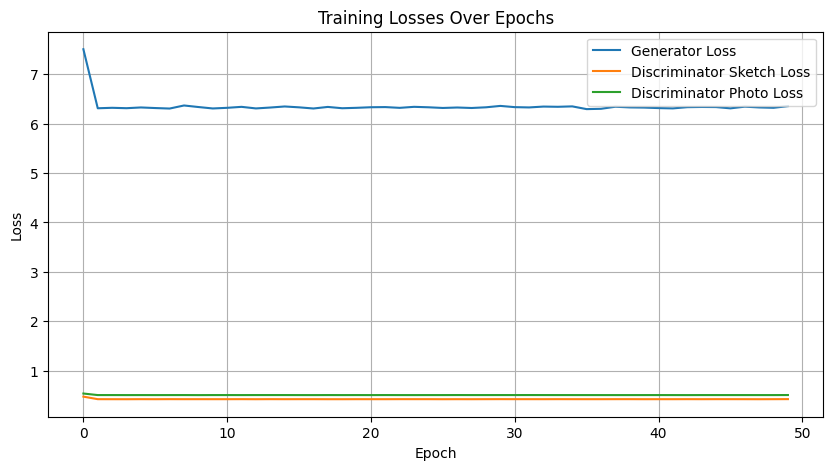

In [ ]:
# Plot training losses
plt.figure(figsize=(10, 5))
plt.plot(losses_g, label='Generator Loss')
plt.plot(losses_d_sketch, label='Discriminator Sketch Loss')
plt.plot(losses_d_photo, label='Discriminator Photo Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Ensure torch_fidelity is installed (run this if not already done)
try:
    from torch_fidelity import calculate_metrics
except ImportError:
    !pip install torch-fidelity -q
    try:
        from torch_fidelity import calculate_metrics
    except ImportError:
        print("Warning: torch-fidelity not installed. FID calculation will be skipped.")
        calculate_metrics = None

# Evaluation function
def evaluate_model(generator, test_loader, device):
    generator.eval()
    real_images = []
    fake_images = []
    ssim_scores = []
    psnr_scores = []
    mae_scores = []
    perceptual_scores = []

    with torch.no_grad():
        for sketches, photos, _ in test_loader:
            sketches = sketches.to(device)
            photos = photos.to(device)
            fake_photos = generator(sketches)

            # Denormalize
            fake_photos_np = fake_photos * 0.5 + 0.5
            photos_np = photos * 0.5 + 0.5
            fake_photos_np = fake_photos_np.cpu().permute(0, 2, 3, 1).numpy()
            photos_np = photos_np.cpu().permute(0, 2, 3, 1).numpy()
            fake_photos_uint8 = (fake_photos_np * 255).astype(np.uint8)
            photos_uint8 = (photos_np * 255).astype(np.uint8)

            for i in range(fake_photos_uint8.shape[0]):
                real_images.append(photos_uint8[i])
                fake_images.append(fake_photos_uint8[i])

                # SSIM
                ssim_score = ssim(photos_uint8[i], fake_photos_uint8[i], channel_axis=2)
                ssim_scores.append(ssim_score)

                # PSNR
                psnr_score = psnr(photos_uint8[i], fake_photos_uint8[i], data_range=255)
                psnr_scores.append(psnr_score)

                # MAE
                mae_score = np.mean(np.abs(photos_np[i] - fake_photos_np[i]))
                mae_scores.append(mae_score)

                # Perceptual Loss
                photos_vgg = photos.clone()
                fake_photos_vgg = fake_photos.clone()
                perceptual_score = mae_loss(vgg(photos_vgg), vgg(fake_photos_vgg))
                perceptual_scores.append(perceptual_score.item())

    # FID Calculation
    real_images = np.stack(real_images)
    fake_images = np.stack(fake_images)
    fid_score = float('inf')  # Default if FID fails
    if calculate_metrics is not None:
        try:
            fid_score = calculate_metrics(
                input1=real_images,
                input2=fake_images,
                cuda=True,
                fid=True,
                verbose=False
            )['frechet_inception_distance']
        except Exception as e:
            print(f"Warning: FID calculation failed: {e}. Skipping FID.")

    # Average metrics
    metrics = {
        'FID': fid_score,
        'SSIM': np.mean(ssim_scores) if ssim_scores else float('nan'),
        'PSNR': np.mean(psnr_scores) if psnr_scores else float('nan'),
        'MAE': np.mean(mae_scores) if mae_scores else float('nan'),
        'Perceptual Loss': np.mean(perceptual_scores) if perceptual_scores else float('nan')
    }

    return metrics, ssim_scores, psnr_scores, mae_scores, perceptual_scores

# Evaluate the model
try:
    metrics, ssim_scores, psnr_scores, mae_scores, perceptual_scores = evaluate_model(G_sketch_to_photo, test_dataloader, device)
    print("\nEvaluation Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
except NameError as e:
    print(f"Error: {e}. Ensure G_sketch_to_photo, test_dataloader, and device are defined.")
except Exception as e:
    print(f"Evaluation failed: {e}")

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 308MB/s]


Evaluation Metrics:
FID: inf
SSIM: 0.0421
PSNR: 9.5589
MAE: 0.2573
Perceptual Loss: 0.7514


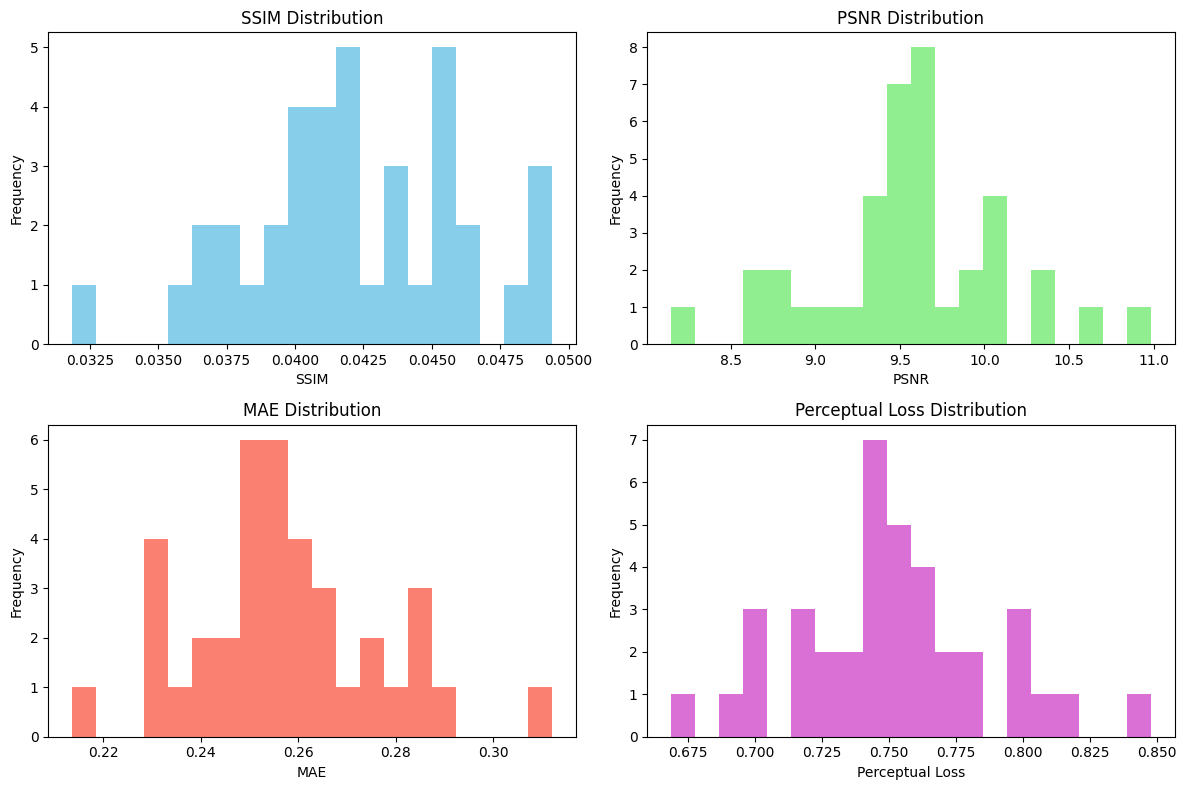

In [ ]:
# Plot evaluation metrics
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].hist(ssim_scores, bins=20, color='skyblue')
axs[0, 0].set_title('SSIM Distribution')
axs[0, 0].set_xlabel('SSIM')
axs[0, 0].set_ylabel('Frequency')

axs[0, 1].hist(psnr_scores, bins=20, color='lightgreen')
axs[0, 1].set_title('PSNR Distribution')
axs[0, 1].set_xlabel('PSNR')
axs[0, 1].set_ylabel('Frequency')

axs[1, 0].hist(mae_scores, bins=20, color='salmon')
axs[1, 0].set_title('MAE Distribution')
axs[1, 0].set_xlabel('MAE')
axs[1, 0].set_ylabel('Frequency')

axs[1, 1].hist(perceptual_scores, bins=20, color='orchid')
axs[1, 1].set_title('Perceptual Loss Distribution')
axs[1, 1].set_xlabel('Perceptual Loss')
axs[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()



Saved generated photo to /content/drive/MyDrive/CUFS/generated_F2-006-01-sz1.png
Saved generated photo to /content/drive/MyDrive/CUFS/generated_F2-011-01-sz1.png
Saved generated photo to /content/drive/MyDrive/CUFS/generated_F2-012-01-sz1.png
Saved generated photo to /content/drive/MyDrive/CUFS/generated_F2-013-01-sz1.png
Saved generated photo to /content/drive/MyDrive/CUFS/generated_F2-027-01-sz1.png


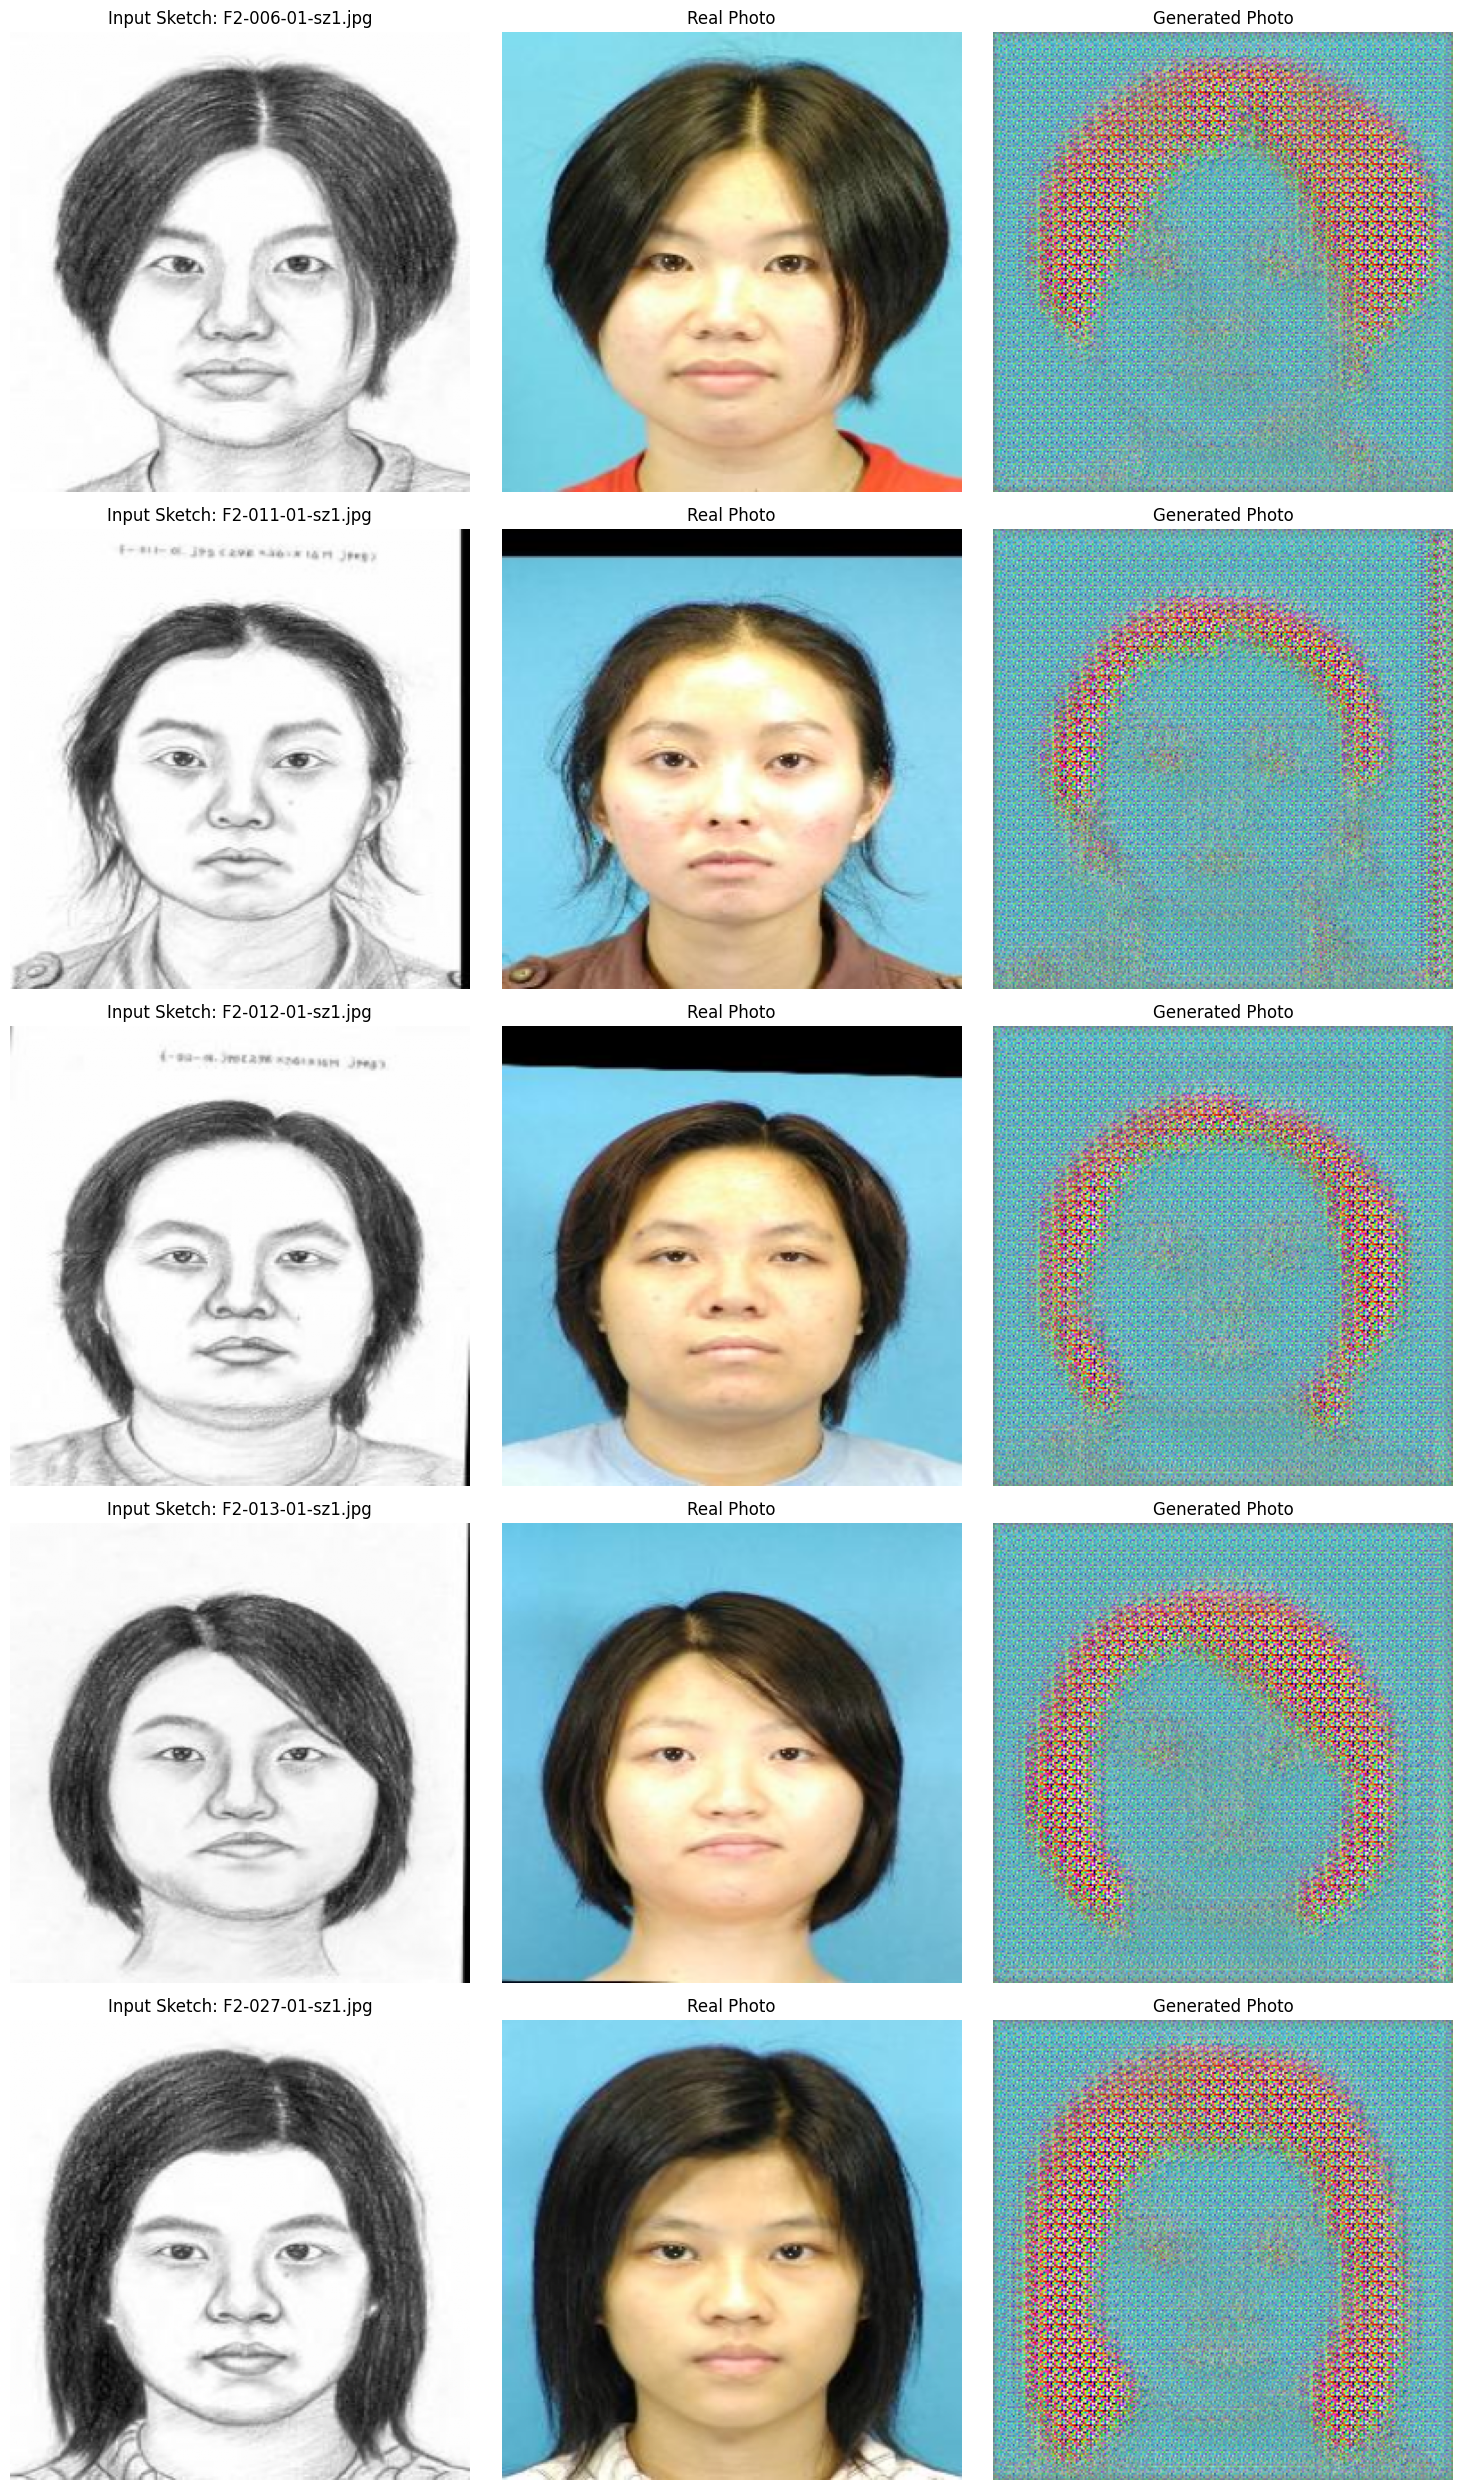

In [ ]:
# Visualize test results
G_sketch_to_photo.eval()
num_display = 5
count = 0

plt.figure(figsize=(15, 5 * num_display))
for i, (sketch, photo, filename) in enumerate(test_dataloader):
    if count >= num_display:
        break
    sketch = sketch.to(device)
    photo = photo.to(device)

    with torch.no_grad():
        fake_photo = G_sketch_to_photo(sketch)

    # Denormalize
    sketch_np = sketch.cpu().squeeze().numpy() * 0.5 + 0.5
    photo_np = photo.cpu().squeeze().permute(1, 2, 0).numpy() * 0.5 + 0.5
    fake_photo_np = fake_photo.cpu().squeeze().permute(1, 2, 0).numpy() * 0.5 + 0.5

    # Convert to uint8
    sketch_uint8 = (sketch_np * 255).astype(np.uint8)
    photo_uint8 = (photo_np * 255).astype(np.uint8)
    fake_photo_uint8 = (fake_photo_np * 255).astype(np.uint8)

    # Plot
    plt.subplot(num_display, 3, count * 3 + 1)
    plt.imshow(sketch_uint8, cmap='gray')
    plt.title(f'Input Sketch: {filename[0]}')
    plt.axis('off')

    plt.subplot(num_display, 3, count * 3 + 2)
    plt.imshow(photo_uint8)
    plt.title('Real Photo')
    plt.axis('off')

    plt.subplot(num_display, 3, count * 3 + 3)
    plt.imshow(fake_photo_uint8)
    plt.title('Generated Photo')
    plt.axis('off')

    # Save generated photo
    output_path = f'/content/drive/MyDrive/CUFS/generated_{filename[0].replace(".jpg", ".png")}'
    cv2.imwrite(output_path, cv2.cvtColor(fake_photo_uint8, cv2.COLOR_RGB2BGR))
    print(f"Saved generated photo to {output_path}")

    count += 1

plt.tight_layout()
plt.show()